# Data Cleaning For Mapping

- Creating dataframes from Gene Labels and Gene Ontology Terms


    - Gene Labels: Extracting the Gene IDs and the labels
    
    - Gene Ontology: Separating genes that appear on the same row

### Gene Labels

In [1]:
# Extract gene_id and label from the gene_labels dataframe
import pandas as pd
gene_labels = pd.read_csv('gene_labels.csv')

gene_id = gene_labels['Metadata_NCBI_Gene_ID']
label = gene_labels['gene_label']

simplified_gene_labels = pd.DataFrame({'GeneID (EntrezGene)': gene_id, 'Label': label})
print(simplified_gene_labels)

all_genes_df = simplified_gene_labels.to_excel('all_genes_ids.xlsx', index=False)

      GeneID (EntrezGene)          Label
0                       2  Indeterminate
1                  127550  Indeterminate
2                   53947       Positive
3                   51146  Indeterminate
4                   65985  Indeterminate
...                   ...            ...
7970                54925  Indeterminate
7971               201516       Positive
7972                79149       Positive
7973                 7746       Positive
7974               151112       Positive

[7975 rows x 2 columns]


### Gene Ontology Terms

In [2]:
# Separating genes that appear on the same row by semicolon
uniprot_df = pd.read_excel("HUMAN_9606_idmapping.xlsx")

cleaned_rows = []

for index, row in uniprot_df.iterrows():
    gene_ids = str(row["GeneID (EntrezGene)"]).split(";") 
    for gene_id in gene_ids:
        new_row = row.copy()
        new_row["GeneID (EntrezGene)"] = gene_id.strip()
        cleaned_rows.append(new_row)
        
gene_ontology = pd.DataFrame(cleaned_rows).dropna(subset=["GeneID (EntrezGene)"]).reset_index(drop=True)
print(gene_ontology)
gene_ontology.to_excel("CleanedDataForMapping.xlsx", index=False)

       UniProtKB-AC      UniProtKB-ID GeneID (EntrezGene)  \
0            P31946       1433B_HUMAN                7529   
1            P62258       1433E_HUMAN                7531   
2            Q04917       1433F_HUMAN                7533   
3            P61981       1433G_HUMAN                7532   
4            P31947       1433S_HUMAN                2810   
...             ...               ...                 ...   
208168       B4DID3      B4DID3_HUMAN                 nan   
208169       H9BQ89      H9BQ89_HUMAN                 nan   
208170       H9C5H6      H9C5H6_HUMAN                 nan   
208171       Q9HAQ5      Q9HAQ5_HUMAN                 nan   
208172   A0A186VNL2  A0A186VNL2_HUMAN                 nan   

                                      Unnamed: 3  \
0       NP_003395.1; NP_647539.1; XP_016883528.1   
1                                    NP_006752.1   
2                                    NP_003396.1   
3                                    NP_036611.2   
4      

# Mapping Script

- Match the Gene Ids found in gene_labels.csv

- Extract and process matching rows from uniprot_df based on gene and protein IDs

In [3]:
# Check if the gene_id from all_genes_df exists in uniprot_df
all_genes_df = pd.read_excel("all_genes_ids.xlsx")
uniprot_df = pd.read_excel("CleanedDataForMapping.xlsx")
gene_to_protein = {}

for gene_id in all_genes_df['GeneID (EntrezGene)']:
    matching_proteins = uniprot_df[uniprot_df['GeneID (EntrezGene)'] == gene_id]['UniProtKB-ID'].tolist()
    gene_to_protein[gene_id] = matching_proteins
    
matched_rows = pd.DataFrame(columns=uniprot_df.columns)
print(matched_rows)

Empty DataFrame
Columns: [UniProtKB-AC, UniProtKB-ID, GeneID (EntrezGene), Unnamed: 3, Unnamed: 4, Unnamed: 5, Unnamed: 6, Unnamed: 7, Unnamed: 8, Unnamed: 9, Unnamed: 10, Unnamed: 11, Unnamed: 12, Unnamed: 13, Unnamed: 14, Unnamed: 15, Unnamed: 16, Unnamed: 17, Unnamed: 18, Unnamed: 19, Unnamed: 20, Unnamed: 21]
Index: []

[0 rows x 22 columns]


In [4]:
# Check if gene ID and protein ID match
for index, row in uniprot_df.iterrows():
    gene_id = row['GeneID (EntrezGene)']
    protein_id = row['UniProtKB-ID']

    if gene_id in gene_to_protein and protein_id in gene_to_protein[gene_id]:
        matched_rows = pd.concat([matched_rows, pd.DataFrame(row).transpose()], ignore_index=True)
        
matched_rows = matched_rows.sort_values('GeneID (EntrezGene)').rename(columns={'Unnamed: 6': 'GO Terms'}).merge(all_genes_df[['GeneID (EntrezGene)', 'Label']], on='GeneID (EntrezGene)', how='left')
print(matched_rows)
matched_rows.to_excel("CleanedDataForFeatureVectors.xlsx", index=False)

      UniProtKB-AC  UniProtKB-ID GeneID (EntrezGene)  \
0           P01023    A2MG_HUMAN                 2.0   
1           F5H5R8  F5H5R8_HUMAN                 9.0   
2           Q400J6  Q400J6_HUMAN                 9.0   
3           P18440    ARY1_HUMAN                 9.0   
4           P11245    ARY2_HUMAN                10.0   
...            ...           ...                 ...   
14835       Q02080   MEF2B_HUMAN         100271849.0   
14836       Q9Y575    ASB3_HUMAN         100302652.0   
14837       P35226    BMI1_HUMAN         100532731.0   
14838       R4GMX3  R4GMX3_HUMAN         100532731.0   
14839       Q9Y3D8    KAD6_HUMAN         102157402.0   

                                              Unnamed: 3  \
0      NP_000005.2; NP_001334352.1; NP_001334353.1; N...   
1      NP_001153647.1; NP_001153648.1; NP_001278891.1...   
2      NP_001153642.1; NP_001153644.1; NP_001153645.1...   
3      NP_000653.3; NP_001153642.1; NP_001153643.1; N...   
4                          

# Feature Vectors

- Creating binary feature vectors that represent whether a GO term is associated with a Gene ID

- Determining which Go terms to include by creating a frequency threshold

In [5]:
# Split go terms by semicolon and create new row for each term
import numpy as np
import matplotlib.pyplot as plt

feature_vector_data = pd.read_excel("CleanedDataForFeatureVectors.xlsx")
cleaned_rows = []

for index, row in feature_vector_data.iterrows():
    terms = str(row["GO Terms"]).split(";")
    for term in terms:
        if row["Label"] == "Indeterminate":
            continue
        new_row = row.copy()
        new_row["GO Terms"] = term.strip()
        cleaned_rows.append(new_row)

cleaned_df = pd.DataFrame(cleaned_rows)
cleaned_df.to_excel("CleanedDataForAnc2vec.xlsx", index=False)
print(cleaned_df)

      UniProtKB-AC  UniProtKB-ID  GeneID (EntrezGene)  \
7           F1T0I5  F1T0I5_HUMAN                   15   
7           F1T0I5  F1T0I5_HUMAN                   15   
7           F1T0I5  F1T0I5_HUMAN                   15   
7           F1T0I5  F1T0I5_HUMAN                   15   
7           F1T0I5  F1T0I5_HUMAN                   15   
...            ...           ...                  ...   
14836       Q9Y575    ASB3_HUMAN            100302652   
14836       Q9Y575    ASB3_HUMAN            100302652   
14836       Q9Y575    ASB3_HUMAN            100302652   
14836       Q9Y575    ASB3_HUMAN            100302652   
14836       Q9Y575    ASB3_HUMAN            100302652   

                                              Unnamed: 3  \
7                                            NP_001079.1   
7                                            NP_001079.1   
7                                            NP_001079.1   
7                                            NP_001079.1   
7              

In [6]:
# Creating term dictionary to store the frequency of each term
term_dictionary = {}
for term in cleaned_df["GO Terms"]:
    if term in term_dictionary:
        term_dictionary[term] = term_dictionary[term] + 1
    else:
        term_dictionary[term] = 1

sorted_dict = dict(sorted(term_dictionary.items(), key=lambda x: x[1], reverse=True))

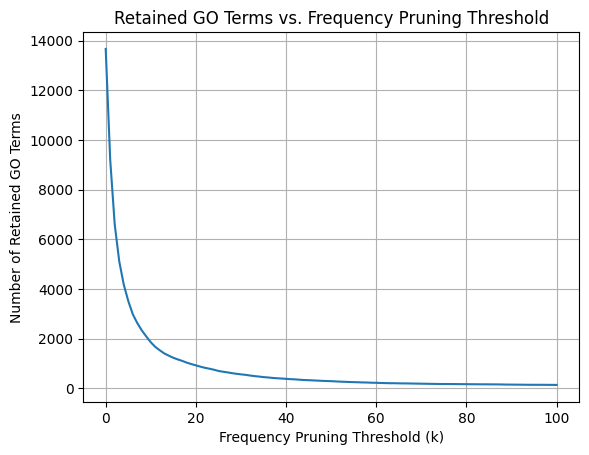

In [7]:
# Plot retained go terms vs the frequency pruning threshold
thresholds = np.arange(0,101,1)

num_retained_terms = []
for threshold in thresholds:
    retained_terms = [term for term, freq in term_dictionary.items() if freq > threshold]
    num_retained_terms.append(len(retained_terms))

plt.plot(thresholds, num_retained_terms)
plt.xlabel("Frequency Pruning Threshold (k)")
plt.ylabel("Number of Retained GO Terms")
plt.title("Retained GO Terms vs. Frequency Pruning Threshold")
plt.grid(True)
plt.savefig("retained_go_terms_vs_threshold.png", dpi=300)
plt.show()

In [8]:
# Set threshold value
threshold_value = 5

new_dict = {key: value for key, value in sorted_dict.items() if value > threshold_value}
go_terms = list(new_dict.keys())
print(len(go_terms))
df = pd.DataFrame({"GO Terms": go_terms})
df.to_excel("go_terms.xlsx", index=False)

3515


In [9]:
# Construct feature vectors
feature_vectors = []

for index, row in cleaned_df.iterrows():
    gene_id = row['GeneID (EntrezGene)']
    uniprot_ac = row['UniProtKB-AC']
    Label = row["Label"]
    go_term = row['GO Terms']

    gene_entry = next((gene for gene in feature_vectors if gene['gene_id'] == gene_id and gene['uniprot_ac'] == uniprot_ac and gene["Label"] ==Label), None)

    if gene_entry is None:
        gene_entry = {'gene_id': gene_id, 'uniprot_ac': uniprot_ac, "Label" : Label, 'feature_vector': [0] * len(go_terms)}
        feature_vectors.append(gene_entry)

    for i, term in enumerate(go_terms):
        if term == go_term:
            gene_entry['feature_vector'][i] = 1

data = [[gene_entry['uniprot_ac'], gene_entry['gene_id'], gene_entry['Label']] + gene_entry['feature_vector'] for gene_entry in feature_vectors]
CleanedDataForMachineLearning = pd.DataFrame(data, columns=['UniprotAC', 'GeneID', 'Label'] + go_terms)
print(CleanedDataForMachineLearning)
CleanedDataForMachineLearning[go_terms] = CleanedDataForMachineLearning[go_terms].astype(int).reset_index(drop=True)
#CleanedDataForMachineLearning.to_excel("CleanedDataForMachineLearning.xlsx", index=False)


       UniprotAC     GeneID     Label  GO:0005634  GO:0005829  GO:0005654  \
0         F1T0I5         15  Positive           0           1           0   
1         Q16613         15  Positive           0           1           0   
2         P49588         16  Positive           0           1           0   
3         B2RUU2         19  Positive           0           0           0   
4         O95477         19  Positive           0           0           0   
...          ...        ...       ...         ...         ...         ...   
9112  A0A1X9RU27  100132074  Positive           1           0           0   
9113      B7U540  100134444  Positive           0           0           0   
9114  A0A024R7K5  100271849  Positive           0           1           1   
9115      Q02080  100271849  Positive           1           1           1   
9116      Q9Y575  100302652  Positive           0           1           0   

      GO:0005737  GO:0005886  GO:0005524  GO:0016020  ...  GO:0005295  \
0 

# Machine Learning

- Models: 
    - Random Forest
    - Logistic Regression (L1 Penalty)
    - Logistic Regression (L2 Penalty)
    - Ridge Regression
    

- ROC Curves: Testing model accuracy

- Feature Importance: Determining which go terms have the largest effect on positive labels

In [10]:
# Defining inputs for machine learning models
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize, LabelEncoder

X = [data['feature_vector'] for data in list(feature_vectors)]
Y = CleanedDataForMachineLearning['Label'].tolist()

label_encoder = LabelEncoder()
y_binary = label_encoder.fit_transform(Y)

cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

### Random Forest

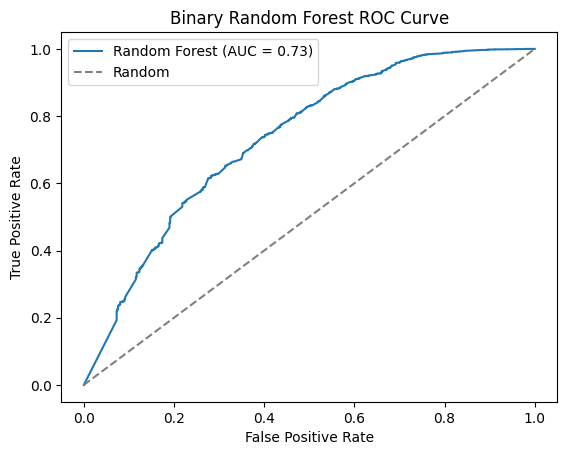

In [11]:
random_forest = RandomForestClassifier()
rf_probs = cross_val_predict(random_forest, X, y_binary, cv=cv, method='predict_proba')[:, 1]
rf_fpr, rf_tpr, _ = roc_curve(y_binary, rf_probs)
rf_auc = auc(rf_fpr, rf_tpr)

plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Binary Random Forest ROC Curve')
plt.legend()
plt.show()

### Logistic Regression (L2 Penalty)

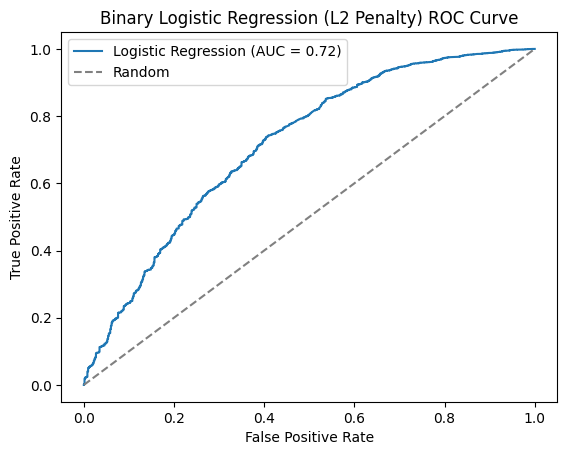

In [12]:
logistic_regression = LogisticRegression()
lr_probs = cross_val_predict(logistic_regression, X, y_binary, cv=cv, method='predict_proba')[:, 1]
lr_fpr, lr_tpr, _ = roc_curve(y_binary, lr_probs)
lr_auc = auc(lr_fpr, lr_tpr)

plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Binary Logistic Regression (L2 Penalty) ROC Curve')
plt.legend()
plt.show()

### Ridge Regression

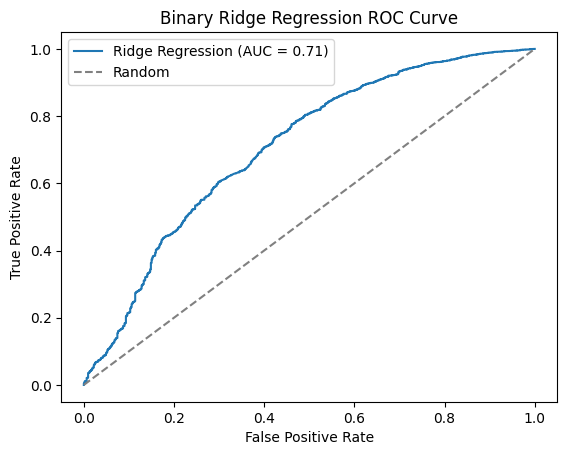

In [13]:
ridge_regression = Ridge()
ridge_probs = cross_val_predict(ridge_regression, X, y_binary, cv=cv)
ridge_fpr, ridge_tpr, _ = roc_curve(y_binary, ridge_probs)
ridge_auc = auc(ridge_fpr, ridge_tpr)

plt.plot(ridge_fpr, ridge_tpr, label=f'Ridge Regression (AUC = {ridge_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Binary Ridge Regression ROC Curve')
plt.legend()
plt.show()

### Logistic Regression (L1 Penalty)

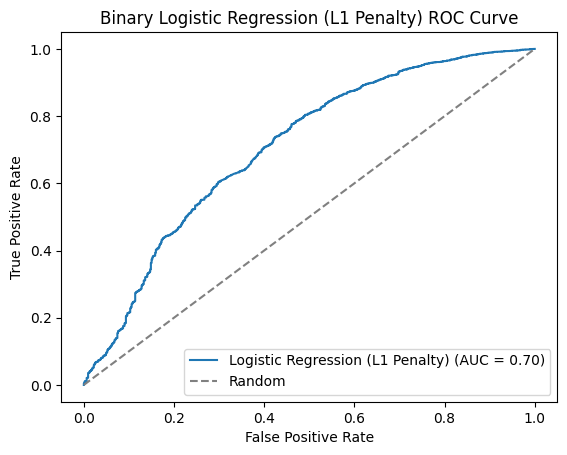

In [14]:
L1 = LogisticRegression(penalty = 'l1', solver = 'liblinear')
l1_probs = cross_val_predict(L1, X, y_binary, cv=cv, method='predict_proba')[:, 1]
l1_fpr, l1_tpr, _ = roc_curve(y_binary, l1_probs)
l1_auc = auc(l1_fpr, l1_tpr)

plt.plot(ridge_fpr, ridge_tpr, label=f'Logistic Regression (L1 Penalty) (AUC = {l1_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Binary Logistic Regression (L1 Penalty) ROC Curve')
plt.legend()
plt.show()

### Overall ROC Curve

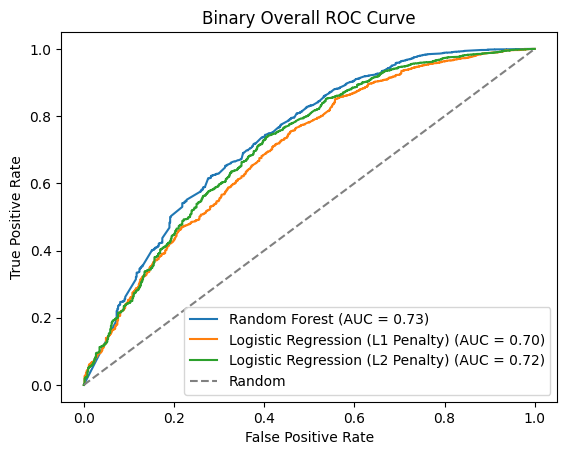

In [15]:
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot(l1_fpr, l1_tpr, label=f'Logistic Regression (L1 Penalty) (AUC = {l1_auc:.2f})')
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (L2 Penalty) (AUC = {lr_auc:.2f})')
#plt.plot(ridge_fpr, ridge_tpr, label=f'Ridge Regression (AUC = {ridge_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Binary Overall ROC Curve')
plt.legend()
plt.savefig('BinaryOverall.png',bbox_inches='tight')
plt.show()

### Random Forest Feature Importance

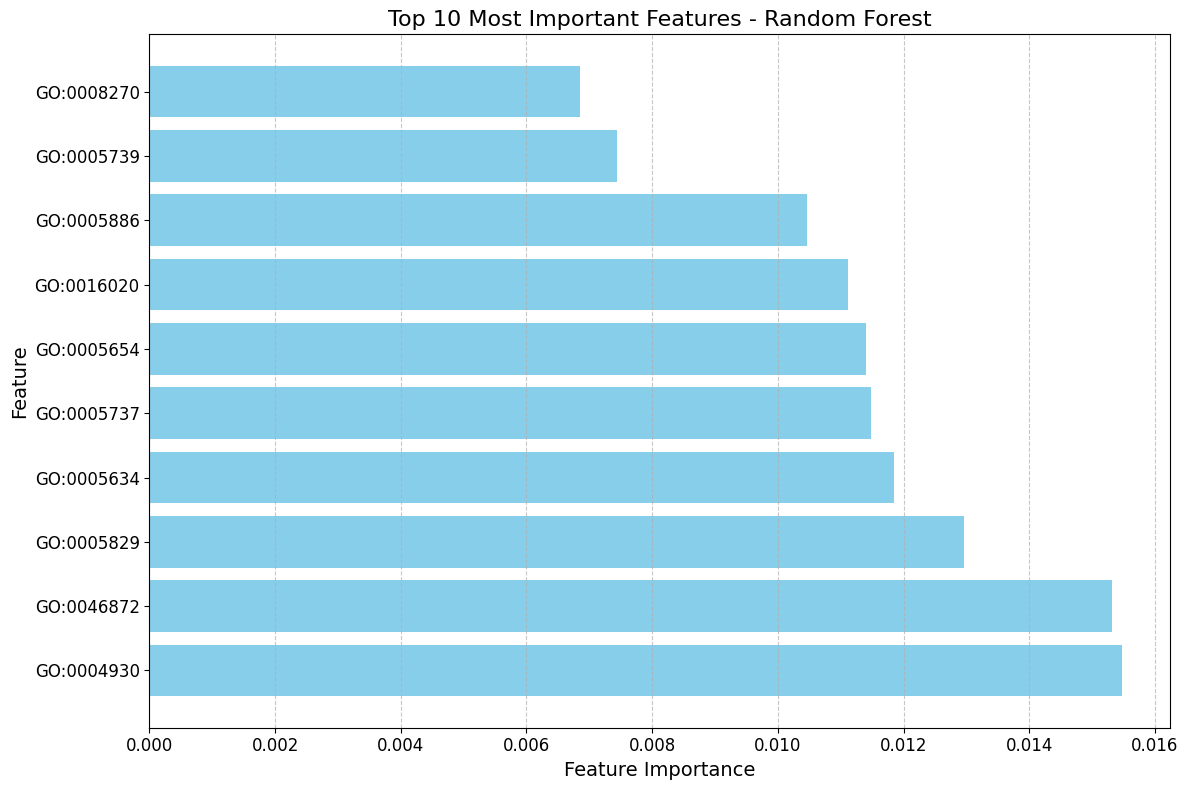

In [16]:
random_forest.fit(X, y_binary)
feature_importances = random_forest.feature_importances_
feature_importance_dict = dict(zip(CleanedDataForMachineLearning.columns[3:], feature_importances))
sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))
top_features = list(sorted_feature_importance.keys())[:10]
top_feature_importance = {feature: sorted_feature_importance[feature] for feature in top_features}

plt.figure(figsize=(12, 8))
plt.barh(list(top_feature_importance.keys()), list(top_feature_importance.values()), color='skyblue')
plt.xlabel('Feature Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Top 10 Most Important Features - Random Forest', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('FeatureImportanceRF.png', bbox_inches='tight', dpi=600)
plt.show()

### Logistic Regression (L2 Penalty) Feature Importance

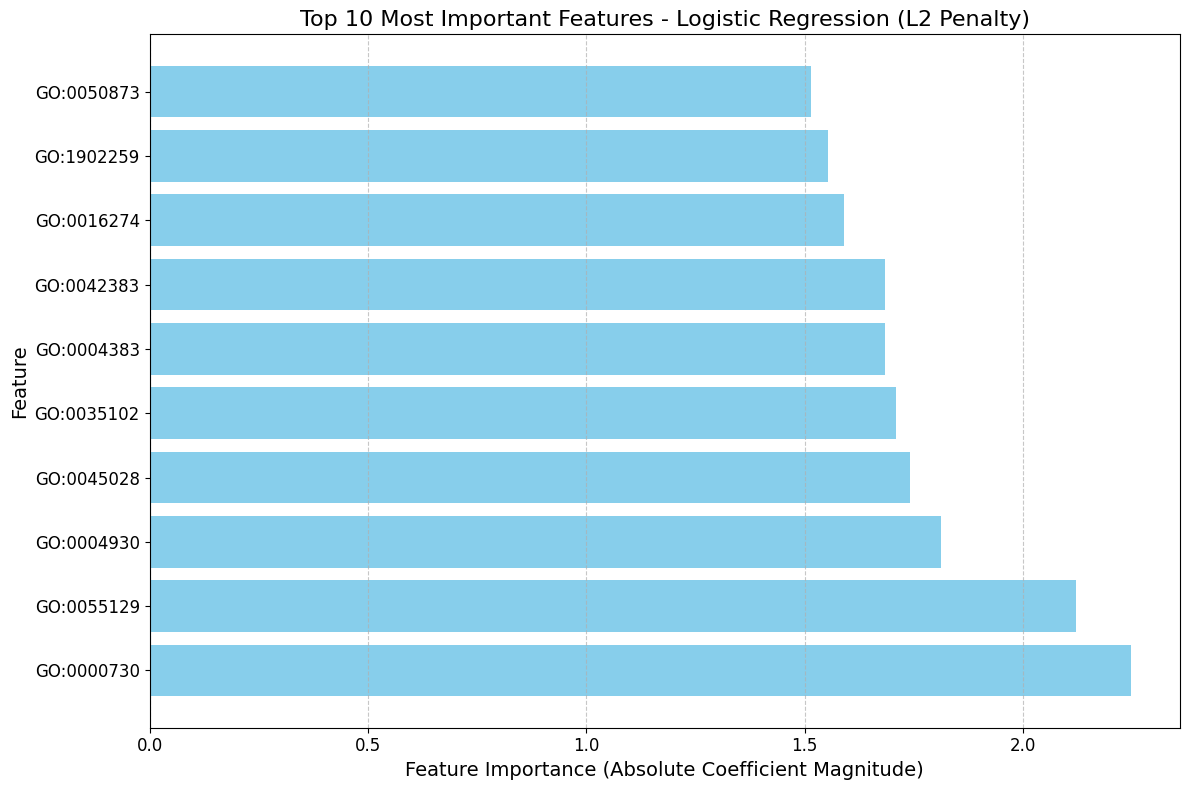

In [17]:
# Train the Logistic Regression model on the data
logistic_regression.fit(X, y_binary)
feature_coefficients = np.abs(logistic_regression.coef_[0])
feature_importance_dict = dict(zip(CleanedDataForMachineLearning.columns[3:], feature_coefficients))
sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))
top_features = list(sorted_feature_importance.keys())[:10]
top_feature_importance = {feature: sorted_feature_importance[feature] for feature in top_features}

plt.figure(figsize=(12, 8))
plt.barh(list(top_feature_importance.keys()), list(top_feature_importance.values()), color='skyblue')
plt.xlabel('Feature Importance (Absolute Coefficient Magnitude)', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Top 10 Most Important Features - Logistic Regression (L2 Penalty)', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('FeatureImportanceLR.png', bbox_inches='tight', dpi=600)
plt.show()

### Ridge Regression Feature Importance

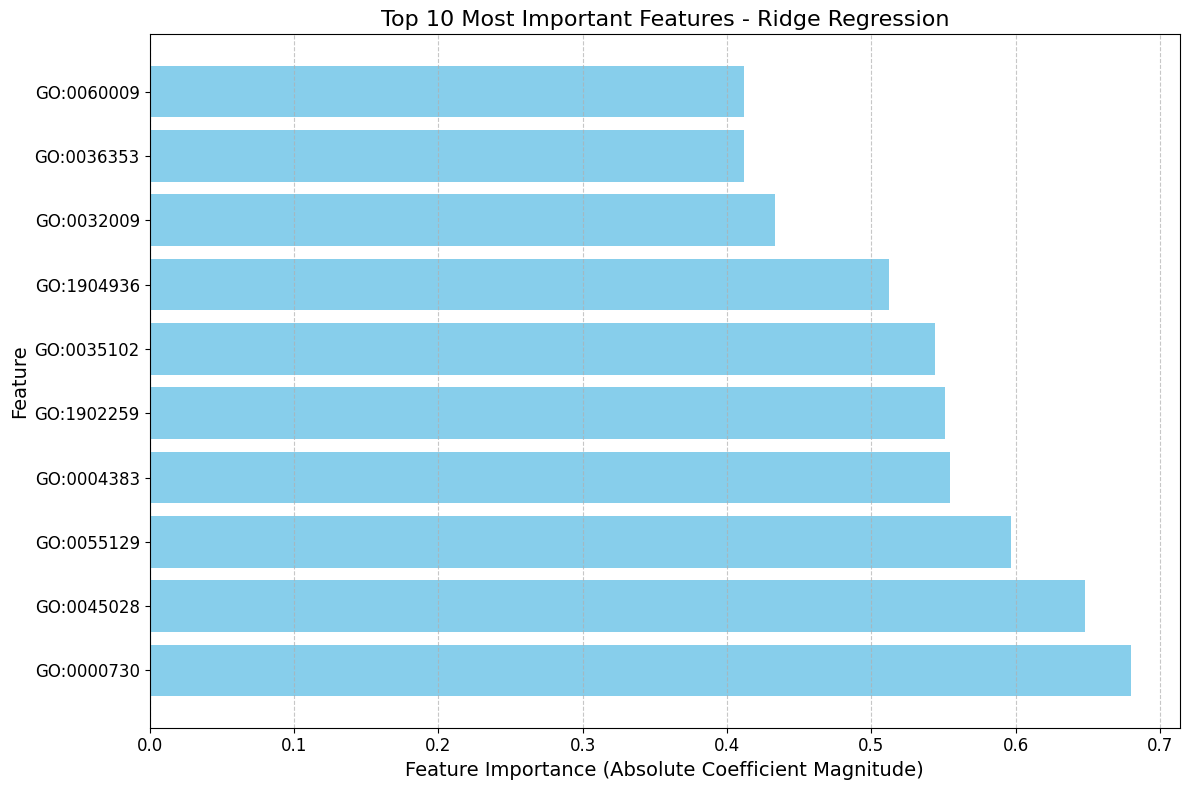

In [18]:

ridge_regression.fit(X, y_binary)
feature_coefficients = np.abs(ridge_regression.coef_)
feature_importance_dict = dict(zip(CleanedDataForMachineLearning.columns[3:], feature_coefficients))
sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))
top_features = list(sorted_feature_importance.keys())[:10]
top_feature_importance = {feature: sorted_feature_importance[feature] for feature in top_features}

plt.figure(figsize=(12, 8))
plt.barh(list(top_feature_importance.keys()), list(top_feature_importance.values()), color='skyblue')
plt.xlabel('Feature Importance (Absolute Coefficient Magnitude)', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Top 10 Most Important Features - Ridge Regression', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('FeatureImportanceRR.png', bbox_inches='tight', dpi=600)
plt.show()

### Logistic Regression (L1 Penalty) Feature Importance

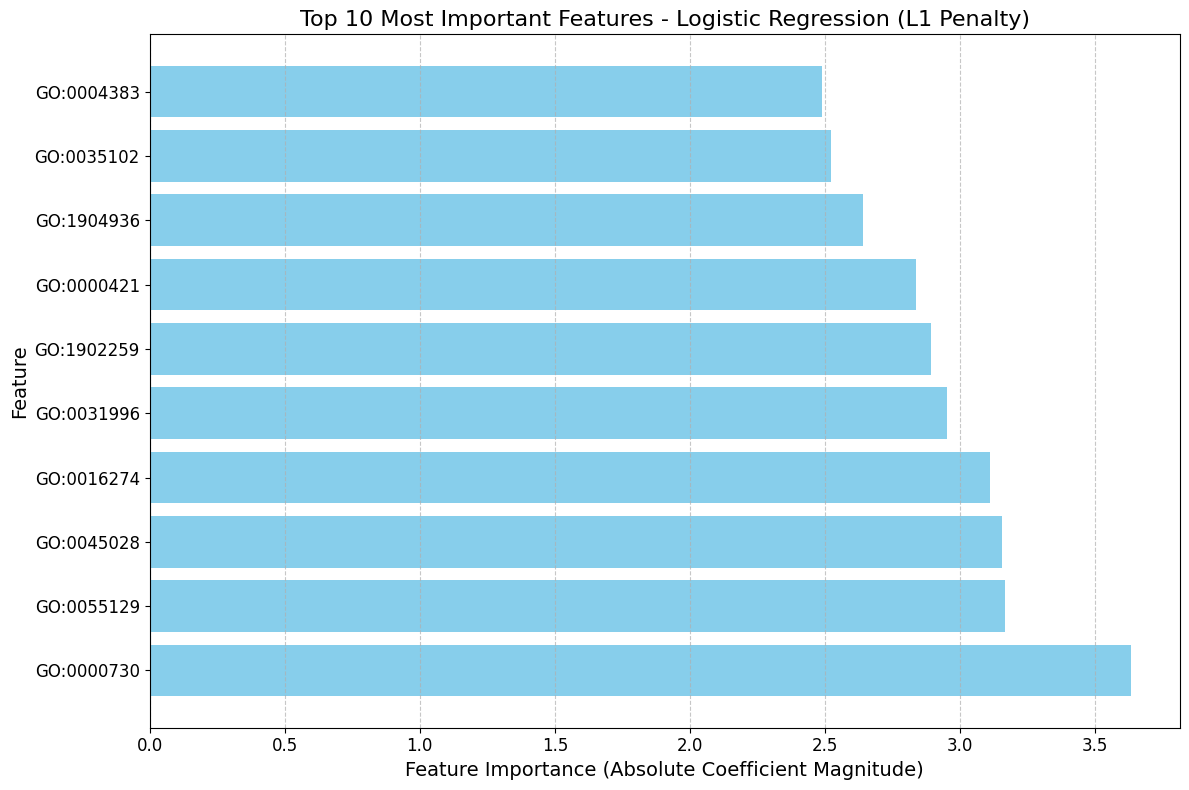

In [19]:

L1.fit(X, y_binary)
feature_coefficients = np.abs(L1.coef_[0])
feature_importance_dict = dict(zip(CleanedDataForMachineLearning.columns[3:], feature_coefficients))
sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))
top_features = list(sorted_feature_importance.keys())[:10]
top_feature_importance = {feature: sorted_feature_importance[feature] for feature in top_features}

plt.figure(figsize=(12, 8))
plt.barh(list(top_feature_importance.keys()), list(top_feature_importance.values()), color='skyblue')
plt.xlabel('Feature Importance (Absolute Coefficient Magnitude)', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Top 10 Most Important Features - Logistic Regression (L1 Penalty)', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('FeatureImportanceL1.png', bbox_inches='tight', dpi=600)
plt.show()